In [1]:
import torch

In [2]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [3]:
from pycocotools.coco import COCO

In [4]:
coco = COCO('/nmnt/x04-hdd/coco_dataset/annotations/instances_train2014.json')

loading annotations into memory...
Done (t=7.52s)
creating index...
index created!


In [5]:
# cat_ids = coco.getCatIds()
# img_ids = set()
# for cat_id in cat_ids:
#     img_ids.update(coco.getImgIds(catIds=[cat_id]))
    
# img_ids = list(img_ids)

cat_ids = []
img_ids = coco.getImgIds(catIds=cat_ids)

In [6]:
len(img_ids)

82783

In [7]:
from imageio import imread
from functools import lru_cache
from skimage.transform import rescale

def load_single(img_id):
    image = coco.loadImgs([img_id])[0]
    anns = coco.loadAnns(coco.getAnnIds(imgIds=image['id']))
    img = imread(f'/nmnt/x04-hdd/coco_dataset/train2014/{image["file_name"]}')    
#     scale = 600 / min(img.shape[:2])
#     boxes = scale * np.array()
    boxes = [x['bbox'] for x in anns if x['category_id'] in cat_ids or not cat_ids]
    return img, boxes
#     return rescale(img, scale, mode='constant'), boxes.tolist()

def load_img():
    return load_single(np.random.choice(img_ids))

In [8]:
from matplotlib import patches

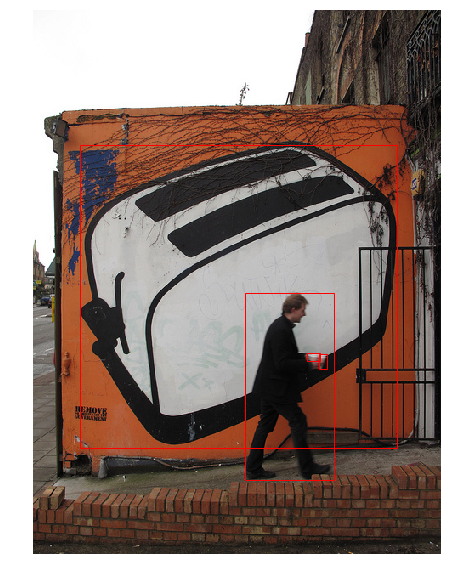

In [9]:
img, boxes = load_img()
_, ax = plt.subplots(1, figsize=(10,10))
ax.imshow(img)
ax.set_axis_off()
for x, y, w, h in boxes:
    ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none'))

In [10]:
from utils import *
from model import *

In [11]:
lambda_ = 1

In [12]:
anchors = get_anchor_shapes(scales=[16, 32, 64, 128], ratios=[1, .5, 2])

In [13]:
from torchvision.models import resnet

In [14]:
from torch.autograd import Variable

In [15]:
first_stage = nn.Sequential(
    ResNetWrapper(resnet.resnet50(pretrained=True)),
    RPN(2048, 256, 3, len(anchors))
).cuda()

In [16]:
cls_loss = nn.BCEWithLogitsLoss()
reg_loss = nn.SmoothL1Loss()

In [17]:
optimizer = torch.optim.Adam(first_stage.parameters(), lr=1e-3)

In [18]:
from tensorboard_easy import Logger

logger = Logger('/nmnt/media/home/memax/tb_garbage/pre')
log_c = logger.make_log_scalar('classification')
log_r = logger.make_log_scalar('regression')
log_s = logger.make_log_scalar('sum')

In [19]:
from tqdm import tqdm_notebook as tqdm

In [20]:
from dpipe.torch.model import set_lr

In [93]:
set_lr(optimizer, 1e-7);

In [119]:
for _ in tqdm(range(1)):
    img, boxes = load_img()
    if not boxes or img.ndim != 3:
        continue
    
    boxes = np.random.permutation(boxes)
    
    x = Variable(torch.from_numpy(img.transpose(2, 0, 1)[None])).float().cuda()
    c, b = first_stage(x)
    
    scale = np.array(x.shape[-2:]) / b.shape[-2:]
    coordinates = get_grid(b.shape[-2:]) * scale[:, None, None]
    masks, params = get_all_masks(coordinates, boxes, anchors)
    masks, params = masks[None], params[None]
    
    if not masks.any():
        continue
    
    masks_r = masks.repeat(4, 1)
    t_mask = torch.from_numpy(masks_r.astype('uint8')).cuda()
    
    loss_c = cls_loss(c, Variable(torch.from_numpy(masks.astype('float32')).cuda()))
    loss_r = reg_loss(b[t_mask], Variable(torch.from_numpy(params[masks_r].astype('float32')).cuda()))
    loss = loss_c + lambda_ * loss_r

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    log_c(loss_c.data.cpu()[0])
    log_r(loss_r.data.cpu()[0])
    log_s(loss.data.cpu()[0])

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

100 0.95837015


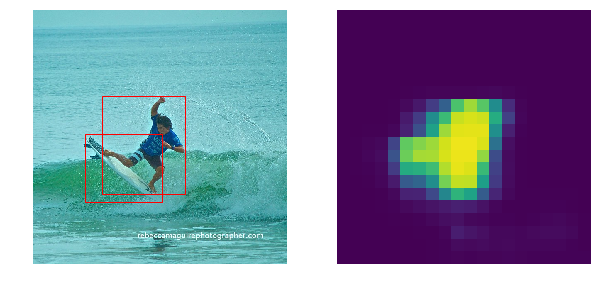

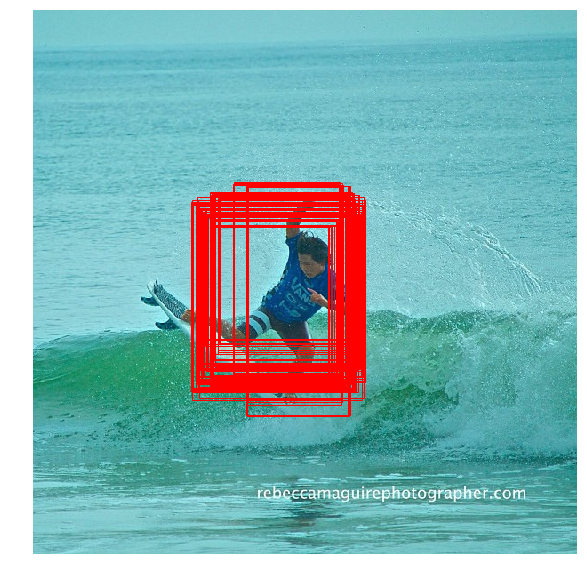

In [120]:
probs = torch.sigmoid(c).data.cpu().numpy()[0]

ax, ax2 = plt.subplots(1, 2, figsize=(10,10))[1]
ax.imshow(img)
ax.set_axis_off()
for x, y, w, h in boxes:
    ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none'))

ax2.imshow(probs.mean(0), vmax=1)
ax2.set_axis_off()
    
pred = b[0].data.cpu().numpy()
pred = pred.reshape(-1, 4, *pred.shape[1:])

a_s = anchors[..., None, None]

space, shape = pred[:, :2], pred[:, 2:]
space = space * a_s + coordinates[None]
shape = a_s * np.exp(shape)

order = probs.copy().flatten()
order.sort()
th = max(order[-100], .5)
mask = probs >= th
print(mask.sum(), th)

xs, ys = space[:, 0][mask], space[:, 1][mask]
ws, hs = shape[:, 0][mask], shape[:, 1][mask]

_, ax = plt.subplots(1, figsize=(10,10))
ax.imshow(img)
ax.set_axis_off()
for x, y, w, h in zip(xs, ys, ws, hs):
    ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none'))